# Metadata

```yaml
Course:    DS 5001
Module:    09 Lab
Topic:     Word2Vec
Author:    R.C. Alvarado
Date:      27 March 2024 (revised)
```

**Purpose:** We create word embeddings with novel data using word2vec and visualize results with tSNE.

# Set Up

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
# Adjust this for a new corpus
data_prefix = 'winereviews'
table_dir =  f'{data_home}/{data_prefix}'
OHCO = ['doc_id', 'sent_id', 'token_id']
# PARA = OHCO[:4] # Paragraphs
# SENT = OHCO[:5] # Sentences
BAG = OHCO[:1]
# BAG = SENT

In [38]:
# word2vec parameters
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [39]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE
import plotly_express as px

In [40]:
import gensim
gensim.__version__

'4.3.0'

# Import `TOKENS` and `VOCAB`

We import data from the TOKEN table of the novels corpus, excluding proper nouns.

In [6]:
TOKENS = pd.read_csv(f'{table_dir}/{data_prefix}-TOKENS.csv').set_index(OHCO)

In [7]:
TOKENS.head()

token term_str  term_id
doc_id sent_id token_id                           
336    0       0          Gritty   gritty     7200
               1         heavily  heavily     7493
               2         roasted  roasted    13107
               3          aromas   aromas     1107
               5         peanuts  peanuts    11308

In [8]:
VOCAB = pd.read_csv(f'{table_dir}/{data_prefix}-VOCAB.csv').set_index('term_str')

In [9]:
VOCAB = VOCAB[~VOCAB.index.isna()] # There is NaN in the index for some reason

In [10]:
VOCAB.sample(5)

,n,f,stem,sw,go
term_str,,,,,
location,5,0.000007,locat,False,True
pâté,5,0.000007,pâté,False,True
hollow,67,0.000087,hollow,False,True
heat,160,0.000208,heat,False,True
explodes,44,0.000057,explod,False,True


# Convert to Gensim

We now create a Gensim-style corpus of docs, a list of lists of tokens.

In [13]:
docs = TOKENS.dropna(subset='term_str')\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs

In [14]:
print(docs[:2])

[['gritty', 'heavily', 'roasted', 'aromas', 'peanuts', 'herbal', 'berry', 'fruits', 'lead', 'scratchy', 'tannic', 'palate', 'tastes', 'burnt', 'oak', 'raw', 'plum', 'currant', 'finish', 'tastes', 'briny', 'harsh', 'version', 'wine', 'much', 'better', 'rough', 'front', 'back'], ['easy', 'inviting', 'selection', 'mentholated', 'streak', 'soft', 'red', 'currant', 'cherry', 'core', 'wine', 'light', 'breezy', 'palate', 'offers', 'thin', 'quickly', 'flavors', 'fleeting', 'finish']]


In [15]:
vocab = Dictionary(docs)

# Generate word embeddings with Gensim's module

In [41]:
# word2vec.Word2Vec?

In [42]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [43]:
model.wv.vectors

array([[-0.22465543,  0.216912  , -0.14310533, ...,  0.03189224,
        -0.62758934, -0.07047216],
       [-0.4541738 , -0.6512267 , -0.01495968, ...,  0.29976606,
        -0.06596977,  0.16135263],
       [-0.11020721, -0.7796961 , -0.15975259, ..., -0.20826404,
         0.46222496, -0.19411616],
       ...,
       [-0.00203684, -0.06420369, -0.00328736, ..., -0.169405  ,
        -0.03235534, -0.09219577],
       [ 0.04366657, -0.10064843, -0.04870199, ...,  0.04035628,
         0.12795296, -0.10140481],
       [ 0.0563351 , -0.02222408,  0.11840609, ..., -0.05235429,
         0.05344206, -0.12534146]], dtype=float32)

# Visualize with tSNE

## Convert model to data frame

In [44]:
# VOCAB['gsid'] = pd.DataFrame([i for i in vocab.items()], columns=['gsid', 'term_str']).set_index('term_str')
# VOCAB = VOCAB.dropna(subset='gsid').copy()
# VOCAB.gsid = VOCAB.gsid.astype(int)

In [45]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [46]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [47]:
WV

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
term_str,,,,,,,,,,,,,,,,,,,,,
absolutely,0.099093,0.064579,0.267962,0.166052,-0.033146,-0.342578,-0.095568,0.174613,-0.118630,0.044195,...,0.052810,-0.079218,-0.055284,-0.043584,0.079478,0.097729,0.192483,-0.223339,-0.132707,-0.201843
accent,-0.017115,-0.138501,-0.023477,0.104469,0.172116,0.070075,0.100121,0.123788,0.062636,0.293556,...,0.339185,-0.046031,-0.035730,0.089275,0.091049,0.196325,-0.177999,0.071094,0.092136,0.097967
accented,-0.011005,-0.288276,-0.003918,0.101591,0.111313,0.164510,0.065790,0.093552,0.215008,0.431881,...,0.465311,-0.099395,-0.039191,0.044861,0.109773,0.319016,-0.291150,0.022382,0.078540,0.121261
accents,0.116254,0.014120,-0.113475,-0.105489,0.171581,0.112060,0.087727,0.304921,0.011980,0.196260,...,0.381148,-0.069535,0.008271,0.342950,0.237396,0.222805,-0.083334,0.114431,0.140692,-0.203312
acceptable,-0.047733,0.026004,0.118941,0.040494,0.128129,-0.048235,-0.006212,0.101067,-0.074312,0.138770,...,0.128641,-0.038420,0.091267,-0.189442,0.138766,0.045597,0.108077,-0.167039,-0.117756,0.081143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youthfully,0.283211,-0.086680,-0.084301,-0.297820,-0.370266,0.114065,0.446862,0.483929,-0.064437,0.151265,...,0.055889,0.198692,0.128240,0.131961,0.133621,0.241342,-0.043116,-0.139194,-0.093437,-0.143503
zest,0.285879,-0.514171,0.053237,-0.390716,0.170693,0.015279,0.228175,0.509384,0.094332,0.525895,...,0.000073,0.492766,0.522215,0.080520,0.238023,0.773269,-0.063215,0.106784,-0.615807,1.028685
zesty,0.295123,-0.149844,0.196532,-0.281882,-0.363669,-0.052038,0.045058,0.409679,0.057054,0.434608,...,-0.043595,0.351797,0.644480,-0.217797,0.184013,0.466817,0.124288,-0.258425,-0.511616,0.362984


## Use ScikitLearn's TSNE library

In [48]:
tsne_engine = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [49]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [50]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [51]:
TSNE

,x,y
term_str,,
absolutely,-2.072831,12.576197
accent,29.415913,-4.351225
accented,34.062538,-4.233188
accents,32.143837,2.001839
acceptable,7.655654,-11.544814
...,...,...
youthfully,-6.644920,26.301682
zest,35.264717,-21.352770
zesty,-1.769280,-10.772165


## Plot the coordinates

In [52]:
X = TSNE.join(VOCAB, how='left')

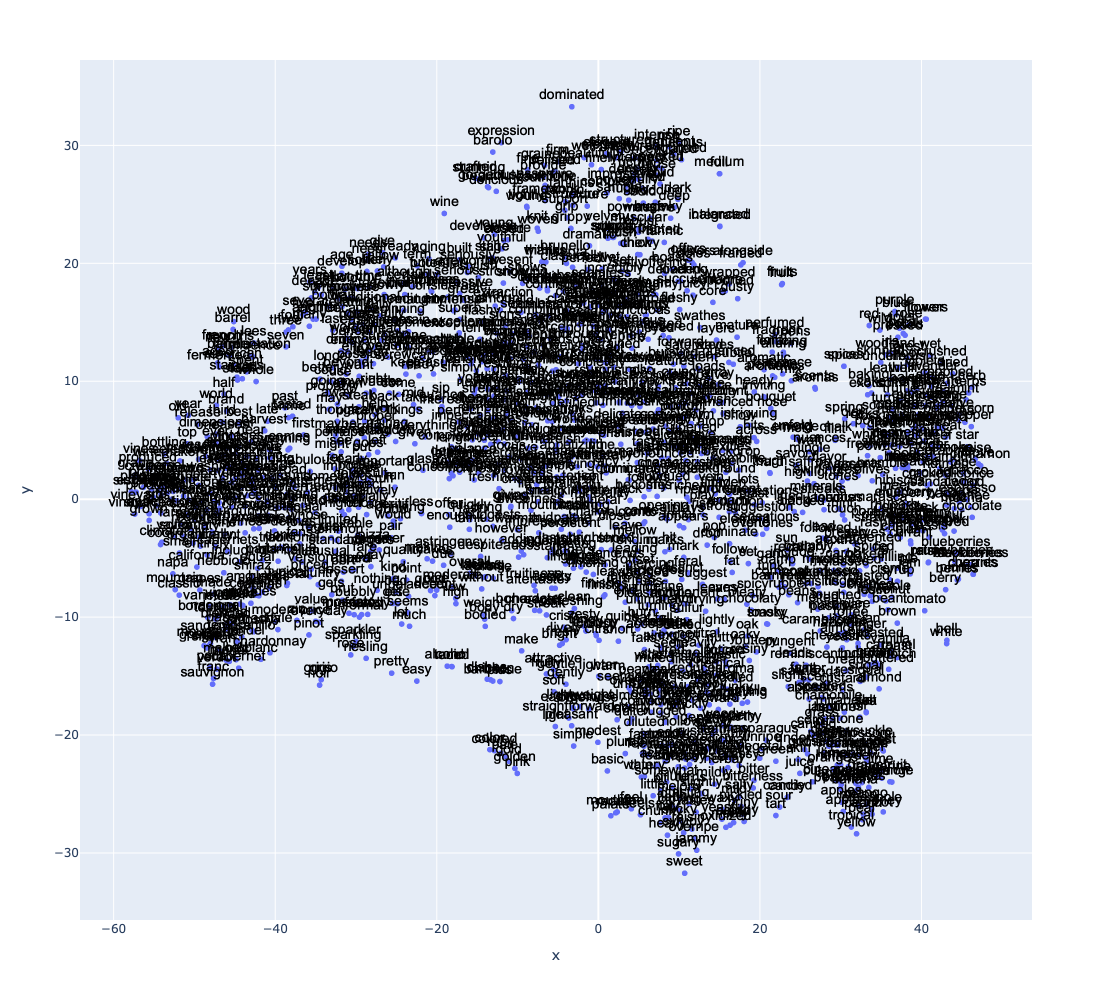

In [53]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           hover_name='term_str',          
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [56]:
model.wv.most_similar?

Signature:
model.wv.most_similar(
    positive=None,
    negative=None,
    topn=10,
    clip_start=0,
    clip_end=None,
    restrict_vocab=None,
    indexer=None,
)
Docstring:
Find the top-N most similar keys.
Positive keys contribute positively towards the similarity, negative keys negatively.

This method computes cosine similarity between a simple mean of the projection
weight vectors of the given keys and the vectors for each key in the model.
The method corresponds to the `word-analogy` and `distance` scripts in the original
word2vec implementation.

Parameters
----------
positive : list of (str or int or ndarray) or list of ((str,float) or (int,float) or (ndarray,float)), optional
    List of keys that contribute positively. If tuple, second element specifies the weight (default `1.0`)
negative : list of (str or int or ndarray) or list of ((str,float) or (int,float) or (ndarray,float)), optional
    List of keys that contribute negatively. If tuple, second element specifies the

In [30]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [54]:
get_most_similar('white')

,term,sim
0,bell,0.724232
1,cracked,0.632838
2,pit,0.574552
3,yellow,0.554187
4,purple,0.539777
5,stone,0.534325
6,riper,0.528491
7,blue,0.494109
8,passion,0.481265
9,tropical,0.478893


In [55]:
get_most_similar('red')

,term,sim
0,wild,0.690256
1,black,0.681147
2,briary,0.618351
3,strawberry,0.587683
4,marasca,0.572644
5,forward,0.554045
6,crunchy,0.548719
7,brambly,0.540754
8,purple,0.535916
9,blue,0.535243


In [57]:
complete_analogy('red', 'heavy', 'white', 3)

,term,sim
0,oily,0.646397
1,flat,0.632229
2,flabby,0.606543


In [32]:
complete_analogy('woman', 'man', 'lady', 5)

,term,sim
0,boy,0.688065
1,gentleman,0.687583
2,doctor,0.680753
3,friend,0.663397
4,master,0.645334


In [33]:
complete_analogy('day', 'night', 'sun', 5)

,term,sim
0,rain,0.842176
1,gates,0.826084
2,twilight,0.812911
3,wind,0.806102
4,clouds,0.798691


In [70]:
complete_analogy('woman','answered','man', 5)

,term,sim
0,replied,0.672718
1,says,0.669190
2,said,0.659242
3,remarked,0.644187
4,saying,0.643100


In [71]:
complete_analogy('man','replied','woman', 5)

,term,sim
0,answered,0.724682
1,truly,0.693492
2,exclaimed,0.690616
3,oh,0.684583
4,thinks,0.681336


In [72]:
complete_analogy('wife', 'appeared', 'husband', 5)

,term,sim
0,seemed,0.802784
1,proved,0.640243
2,believed,0.630207
3,considered,0.607803
4,experienced,0.591214


In [73]:
complete_analogy('husband', 'appeared', 'wife', 5)

,term,sim
0,seemed,0.663734
1,distinguished,0.621346
2,succeeded,0.598477
3,perceived,0.584147
4,sought,0.571337


In [74]:
complete_analogy('man', 'father', 'woman', 5)

,term,sim
0,mother,0.849328
1,husband,0.845066
2,aunt,0.827155
3,niece,0.778856
4,daughter,0.753705


In [75]:
complete_analogy('man', 'husband', 'woman', 5)

,term,sim
0,mother,0.820475
1,aunt,0.816916
2,niece,0.784000
3,father,0.778376
4,daughter,0.731512


In [76]:
complete_analogy('man', 'castle', 'woman', 5)

,term,sim
0,house,0.698088
1,convent,0.684274
2,chateau,0.657860
3,church,0.635959
4,village,0.624091


In [77]:
complete_analogy('woman', 'home', 'man', 5)

,term,sim
0,ready,0.675226
1,station,0.650292
2,rest,0.645577
3,off,0.613166
4,morrow,0.599513


## Similarites

In [34]:
get_most_similar('joy')

,term,sim
0,tender,0.858178
1,despair,0.857970
2,grief,0.857926
3,indignation,0.857510
4,astonishment,0.853664
5,tenderness,0.851100
6,terror,0.849428
7,admiration,0.849296
8,anguish,0.843757
9,sweetness,0.842490


In [35]:
get_most_similar('man')

,term,sim
0,gentleman,0.848631
1,woman,0.808404
2,girl,0.726127
3,fellow,0.724440
4,person,0.703364
5,creature,0.700765
6,peasant,0.667488
7,stranger,0.643133
8,lady,0.621768
9,doctor,0.620519


In [36]:
get_most_similar(positive=['man'], negative=['woman'])

,term,sim
0,he,0.334811
1,order,0.320915
2,case,0.316780
3,his,0.313891
4,rest,0.301026
5,police,0.294852
6,off,0.278098
7,key,0.275395
8,them,0.271355
9,run,0.268759


In [37]:
get_most_similar(positive='woman')

,term,sim
0,gentleman,0.847215
1,girl,0.842816
2,man,0.808404
3,creature,0.772356
4,fellow,0.743919
5,peasant,0.736655
6,lady,0.694711
7,stranger,0.691583
8,poor,0.653012
9,servant,0.649272


In [38]:
get_most_similar(positive=['woman'], negative=['man'])

,term,sim
0,sweet,0.447657
1,revived,0.426239
2,looks,0.409627
3,beloved,0.409554
4,dreadful,0.403111
5,lovely,0.396790
6,extremely,0.389243
7,painful,0.385851
8,shocked,0.383459
9,terror,0.382382


In [39]:
get_most_similar(['man','woman'],['boy','girl'])

,term,sim
0,or,0.446157
1,nor,0.434149
2,human,0.412443
3,such,0.387991
4,than,0.383221
5,produce,0.377250
6,even,0.377130
7,person,0.373402
8,avoid,0.355799
9,render,0.342168


# View with HAC

In [67]:
import sys
sys.path.append(local_lib)
from hac import HAC

In [68]:
WV2 = WV.join(VOCAB.pos_max)
WV2 = WV2[~WV2.pos_max.str.match(r"NNPS?")].iloc[:, :-1]

<Figure size 640x480 with 0 Axes>

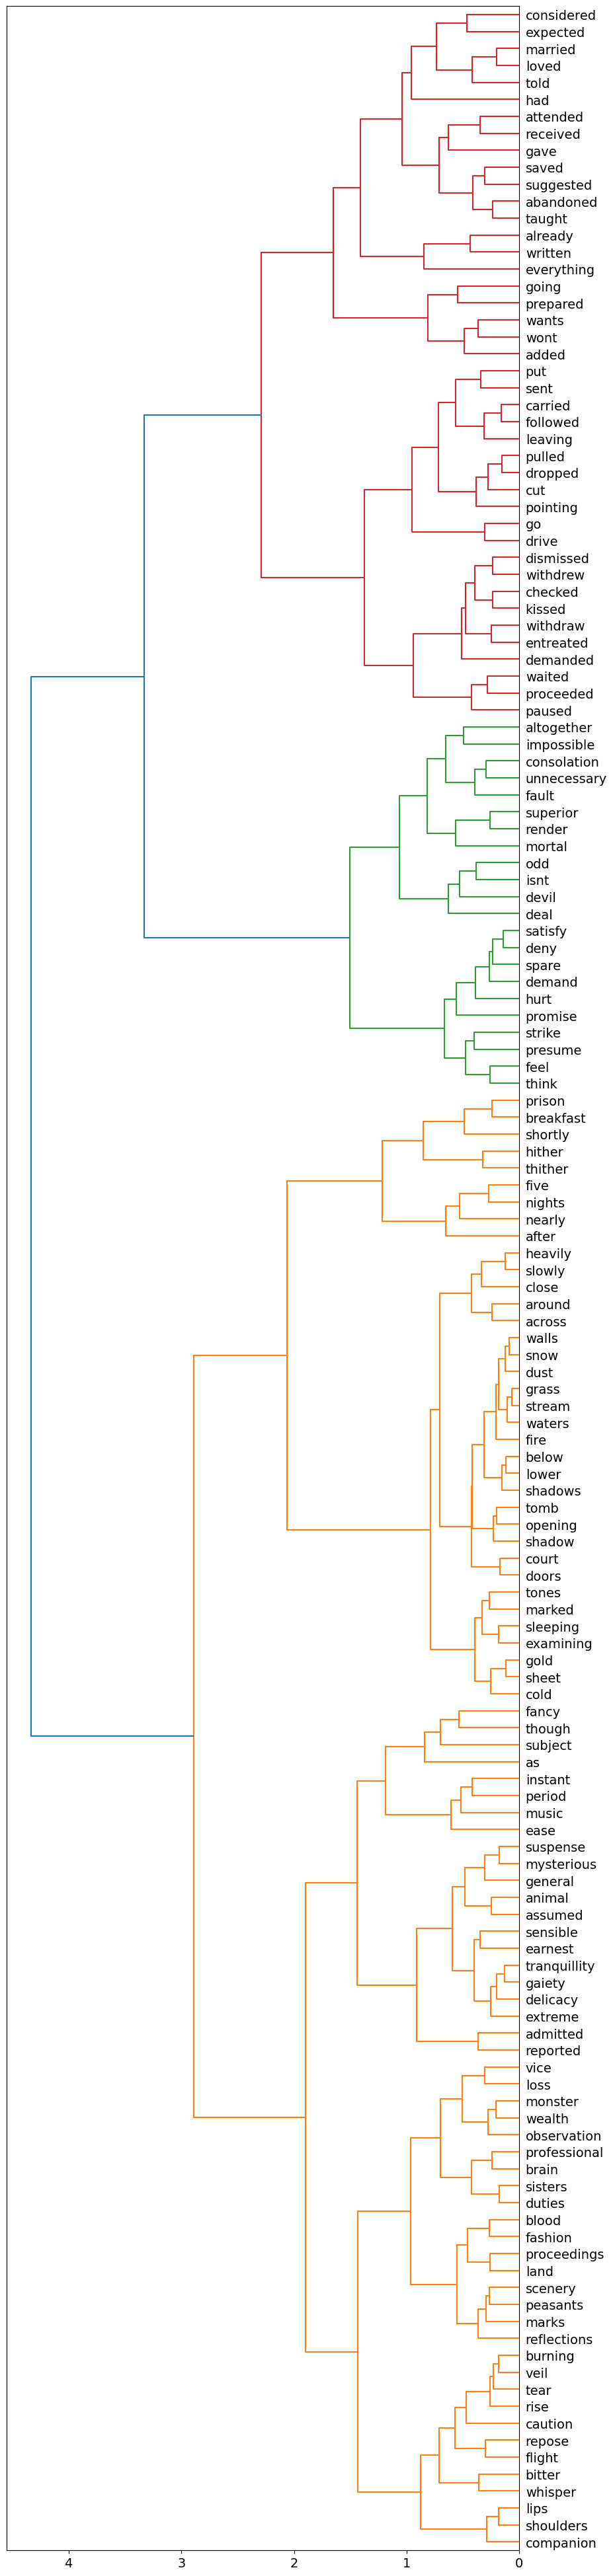

In [69]:
HAC(WV2.sample(150)).plot()

# Save

In [51]:
# W2V = pd.DataFrame(model.wv.vectors_norm, index=model.wv.vocab.keys())
# WV.to_csv('{}/{}-W2V.csv'.format(data_out, data_prefix))
# pd.Series(DOCS).to_csv('{}/{}-GENSIM_DOCS.csv'.format(data_out, data_prefix), index=False, header=False)